In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
from matplotlib import animation


# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

### Now use MD Analysis to calculate no. of frames a center PLGA residues and terminal PLGA residue is with 4 Angstroms of BSA (1.2 nm restrained system)

Import MDAnalysis

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import MDAnalysis.analysis.distances as maa_dist

### First table will be total fractional contacts and oligomer occupancy values for each Rg value 

#### Distance-based analysis 

Find residues that have at least one atom within a cutoff $d = 4.0$ Angstrom near water molecules in BSA/water simulation

Calculate the number of surface bsa residues from a 1 ns BSA/water simulation

In [4]:
#Units of Angstroms 
dmax = 4.0 

In [ ]:
exp_bsa_atoms = np.any(dij_tri <= dmax, axis=1)

# Boolean arrays must be of the same shape as the initial dimensions of the array being indexed.
# In the most straightforward case, the boolean array has the same shape
# Unlike in the case of integer index arrays, in the boolean case,
# the result is a 1-D array containing all the elements in the indexed array corresponding
#       to all the true elements in the boolean array.

bres_wit_dmax = prot[exp_bsa_atoms].residues

In [5]:
## Define a function that does this, Courtesy of MDAnalysis tutorial 
def get_protresd_list(prot_atoms, g2_atoms, dmax, universe):
    """Find all protein residues for which atoms that are within dmax"""
    ro = len(prot_atoms)
    cl = len(g2_atoms)
    dij_tri = np.zeros(shape=(ro,cl))
    dij_tri = maa_dist.distance_array(prot_atoms.positions, g2_atoms.positions, box=universe.trajectory.ts.dimensions)
    exp_prot_atoms = np.any(dij_tri <= dmax, axis=1)
    mk = np.array(prot_atoms[exp_prot_atoms].residues)
    return mk

In [6]:
# Define a function that outputs a dictionary of AA protein number and frame counts, where 
# the inputs will be number of frames, universe, prot and group 2 atom group, and dmax 
# Write function that takes a no of total frames, protein atom positions and group 2 atoms positions 
# and gives a dictionary of protein AA as keys and frame count as values 

def aa_frmcount(prot_atoms, g2_atoms, dmax, universe, start, end):
    """This function will output a dictionary of AA protein number and its corresponding frame count and occupancy"""
    
    aa_dict = {}
    laa = np.zeros(shape=len(prot_atoms.residues))
    br = np.array(prot_atoms.residues)
    
    for ts in universe.trajectory[start:end]: 
        count = 0
        bsres = get_protresd_list(prot_atoms, g2_atoms, dmax, universe)
        
        if bsres.size == 0: 
            pass
        elif bsres.size != 0: 
            count += 1
            for i in bsres.flat:
                res_ind = np.where(br == i)[0]
                laa[res_ind[0]] = laa[res_ind[0]] + count 
                
    fin_res = np.where(laa != 0)[0]
    
    # Calculate occupancy for each residue 
    for i in fin_res.flat:
        aa_dict[str(list(prot.residues[i:i+1])[0])] = [laa[i], laa[i]/(end - start)]
        
    return aa_dict 

In [7]:
#This function will return number of plga monomers vs BSA AA residue group, no. of PLGA monomers will change 
# depending on current frame, output will be a dictionary of BSA AA groups as keys and PLGA monomers for each frame 
# another dictionary with each BSA residue and no. of PLGA monomers
def grptwocnt_aa(prot_atoms, g2_atoms, dmax, universe):
    """ This function calculates the number of PLGA monomers within 4 A of a BSA AA residue and 
    return a numpy array containing the no of PLGA monomers for each BSA AA residue at one single frame """
    
    gg_dict ={}
    
    plga_mon = maa_dist.distance_array(g2_atoms.positions, prot_atoms.positions, box=universe.trajectory.ts.dimensions)
    
    plga_mon_resd = np.nonzero(plga_mon < dmax)
    
    grptwo = np.array(list(g2_atoms[plga_mon_resd[0]].resids))
    
    p_resds = np.array(list(prot_atoms[plga_mon_resd[1]].resids))
    
    kl = np.unique(grptwo)
    
    la = np.zeros(shape=len(prot_atoms.residues))

    for i in kl.flat:
        count = 0
        res_ind = np.nonzero(grptwo == i)[0]
        hu = np.unique(p_resds[res_ind])
        count += 1
        for j in hu.flat:
            la[j-1] = la[j-1] + count

    fin_res = np.where(la != 0)[0]
    
    # Calculate number of PLGA residues per AA 
    for i in fin_res.flat:
        gg_dict[str(list(prot.residues[i:i+1])[0])] = la[i]

    # Grouping of residues in Smith et al  
    aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
    hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
    polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
    neg_res = ['ASP', 'GLU']
    pos_res = ['ARG', 'HIS', 'LYS']

    frac_res = [neg_res, pos_res, polar_res, hydrophobic_res, aromatic_res]
    
    # For each amino acid type in frac_res, this code chunk saves the frame count in a list and sums them together to 
    # to get a total frame count within the 25 ns trajectory for each AA group in frac_res
    co_grpaa = []

    for row in frac_res:
        fr_list = []
        for j in range(len(row)):
            for key, value in gg_dict.items():
                if row[j] in key:
                    fr_list.append(value)
        co_grpaa.append(sum(fr_list))
        
    return gg_dict, np.array(co_grpaa), la

In [8]:
def gtwo_trjcnt(prot_atoms, g2_atoms, dmax, universe, start, end):
    """This function calcuates the average number of PLGA mononers per BSA AA group and no for each trajectory block"""
    
    sf_lb = ["Negative", "Positive", "Polar", "Hydrophobic", "Aromatic"]
    
    aa_dict = {}
    
    laa = np.zeros(shape=(len(prot_atoms.residues),1,end-start))
    
    trj_aa = np.zeros(shape=(len(sf_lb),1, end-start))
    
    l_final = np.zeros(shape=(len(prot_atoms.residues)))
    
    universe.trajectory[start]
    
    count = -1
    
    for ts in universe.trajectory[start:end]: 
    
        g2_dict, fr_pres, hh_matx = grptwocnt_aa(prot_atoms, g2_atoms, dmax, universe)
        
        count += 1
        
        laa[:,0,count] = hh_matx
 
        trj_aa[:,0,count] = fr_pres
        
        universe.trajectory[end]
        
    al_res = np.where(laa != 0)[0]

    for i in al_res.flat:
        l_final[i] = np.mean(laa[i,0,:])

    for i in range(len(sf_lb)):
        aa_dict[sf_lb[i]] = [np.mean(trj_aa[i,0,:]), np.std(trj_aa[i,0,:])]
    
    return aa_dict, l_final

In [9]:
def frac_cont(frm_count_dict):
    
    a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]
    
    # Grouping of residues in Smith et al  
    aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
    hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
    polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
    neg_res = ['ASP', 'GLU']
    pos_res = ['ARG', 'HIS', 'LYS']

    frac_res = [neg_res, pos_res, polar_res, hydrophobic_res, aromatic_res]
    sf_lbl = ["Negative", "Positive", "Polar", "Hydrophobic", "Aromatic"]
    
    # For each amino acid type in frac_res, this code chunk saves the frame count in a list and sums them together to 
    # to get a total frame count within the 25 ns trajectory for each AA group in frac_res
    co_grpaa = []

    for row in frac_res:
        fr_list = []
        for j in range(len(row)):
            for key, value in frm_count_dict.items():
                if row[j] in key:
                    fr_list.append(value[0])
        co_grpaa.append(sum(fr_list))
        
    # This chunk of code gets an AA count from the above list, in order 
    # to get a total number of residues that contact BSA
    cpl_l = []

    for i in range(len(a_a)):
        count = 0
        for key, value in frm_count_dict.items():
            if a_a[i] in key:
                count += 1
        cpl_l.append(a_a[i]+" "+str(count))   

    # For each AA type in frac_res, this code chunk saves the count for each AA within 4 Angstroms of a PLGA trimer 
    # in a list based on the order in frac_res, then sums the counts to get a total number of AA for each AA type 
    tp_cnt = []   
    
    for row in frac_res:
        nw_l = []
        for i in range(len(row)):
            for j in range(len(cpl_l)):
                if row[i] in cpl_l[j]:
                    nw_l.append(int(cpl_l[j][4:6]))
        tp_cnt.append(sum(nw_l))           
    
    # Get the total count of AA that are within 4 A of PLGA oligomer
    bsum = len(frm_count_dict.keys())
    
    # The code chunk normalized the frame count of each AA group type by the protein surface fraction 
    # of each amino acid type contacted by a polymer surrogate.
    norm_list = []
    for i in range(len(co_grpaa)):
        lk = tp_cnt[i]/bsum
        if lk == 0: 
            norm_list.append(co_grpaa[i])
        elif lk != 0:
            norm_list.append(co_grpaa[i]/(tp_cnt[i]/bsum))
            
    # This conde chunk calculates the fractional contact based on the normalized frame count 
    cont_l = []
    nsum = sum(norm_list)
    for i in range(len(norm_list)):
        cont_l.append(norm_list[i]/nsum)
    
    #Save values in a dictionary 
    nlkts = {}
    for i in range(len(sf_lbl)):
        nlkts[sf_lbl[i]] = [co_grpaa[i], tp_cnt[i], norm_list[i], cont_l[i]]
        
    return nlkts

In [10]:
# I want a list of total fraction of contacts where length is determined by no. of blocks and a dictionary 
# of contact groups as keys and list of fractional contacts as values(length of list will be no. of blocks)
def bavg_frac_cnt(no_of_blks, prot_atoms, g2_atoms, dmax, universe, no_surf, begin, final):
 
    n_size = (final - begin)/no_of_blks
    
    frcb = []
    
    ot_dab = {}
    universe.trajectory[begin]
    
    sf_lbl = ["Negative", "Positive", "Polar", "Hydrophobic", "Aromatic", "total_frac"]

    blk_nparr = np.zeros(shape=((len(sf_lbl)-1),1,no_of_blks))
    
    plga_nparr = np.zeros(shape=((len(sf_lbl)-1),1,no_of_blks), dtype=object)
    
    aares_npa = np.zeros(shape=(1,no_of_blks), dtype=object)
    
    for i in range(no_of_blks):
        
        tpl = []
 
        start = universe.trajectory.frame
        print(start)
    
        end = int(start + n_size)
        print(end)
            
        hn_bcks = aa_frmcount(prot_atoms, g2_atoms, dmax, universe, start, end)
            
        ff_dict = frac_cont(hn_bcks)
        
        nk_dict, res_mat = gtwo_trjcnt(prot_atoms, g2_atoms, dmax, universe, start, end)
        
        lk = len(hn_bcks.keys())
            
        frcb.append(lk/no_surf)

        for key, value in ff_dict.items():
            tpl.append(value[3])
            
        count = 0
        for key, value in nk_dict.items():
            plga_nparr[count,0,i] = np.array(value)
            count += 1
            
        blk_nparr[:,0,i] = tpl  
        
        aares_npa[0,i] = res_mat
        
        universe.trajectory[end]
    # Save fractional contacts for each AA group type, each element in the value array corresponds to a block 
    # calculated value
    for i in range(len(sf_lbl)-1):
        ot_dab[sf_lbl[i]] = blk_nparr[i,0,:]
        
    # Save average no of PLGA monomers and the std deviation for each block for each AA group type into dictionary
    plga_dict = {}
    for i in range(len(sf_lbl)-1):
        plga_dict[sf_lbl[i]] = plga_nparr[i,0,:]
    
    # total fraction of contacts within the specified blocks    
    ot_dab[sf_lbl[5]] = np.array(frcb)   
    
    return ot_dab, plga_dict, aares_npa

In [11]:
def prot_poly_cntmovie(prot_atoms, g2_atoms, dmax, universe, start, end):
    """This function calculates the contact matrix between protein AA residues and group 2 residues at each timestep 
    and returns a multi-dim numpy array saves contact map information"""
    
    universe.trajectory[start]
    
    cnt_un = 0 
    
    pp_mat = np.zeros(shape=(1,end-start), dtype=object)
    
    for ts in universe.trajectory[start:end]:
    
        ro = len(prot_atoms)
        cl = len(g2_atoms)
        dij_tri = np.zeros(shape=(ro,cl))
        dij_tri = maa_dist.distance_array(g2_atoms.positions, prot_atoms.positions, box=universe.trajectory.ts.dimensions)
    
        matfr = np.zeros(shape=(len(prot_atoms.residues),len(g2_atoms.residues)))
    
        pr_pol = np.nonzero(dij_tri < dmax)
        #print(pr_pol)
        
        grptwo = np.unique(np.array(list(g2_atoms[pr_pol[0]].resids)))
    
        p_resds = np.unique(np.array(list(prot_atoms[pr_pol[1]].resids)))
    
        count = 0 
        
        for i in pr_pol[0].flat:
            m_i = prot_atoms[pr_pol[1][count]].resid
            m_j = g2_atoms[i].resid
            matfr[m_i-1,m_j-1] = 1
            count += 1
        
        pp_mat[0,cnt_un] = matfr
        
        cnt_un += 1
        
        universe.trajectory[end]
        
    return pp_mat

In [12]:
def AA_list_org(lorg_list):
    
    """List elements need have 'GLY  XX' as string format, where XX reps the number of GLY residues. Output is a
    sorted list of 'AA XX' according to the below order.  """
    
    hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
    polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
    neg_res = ['ASP', 'GLU']
    pos_res = ['ARG', 'HIS', 'LYS']

    all_res = [pos_res, neg_res, polar_res, hydrophobic_res]
    #Change order of residues before making the bar graph
    # (1) Positively charged
    # (2) Negatively charged
    # (3) Polar residues 
    # (4) Hydrophobic residues 
    
    # This chunk of code sorts the counts of each AA that have 1001 or 1002 frame count based 
    # on the AA order in all_res
    arr_list = []

    for row in all_res:
        for i in range(len(lorg_list)):
            for j in range(len(row)):
                if row[j] == lorg_list[i][0:3]:
                    arr_list.append(lorg_list[i])
                    
    #This chunk of code splits the list arr_list to makes the AA: count of 1001 or 1002 frames data plottable 
    f_list = []
    fn_list = []
    for i in range(len(arr_list)):
        f_list.append(arr_list[i][0:3])
        fn_list.append(int(arr_list[i][5:7]))
        
    return f_list, fn_list

Now load BSA/water trajectory to compare the frame counts values from VMD 

In [ ]:
# Load universe of the BSA/water simulation
bsa_wat = mda.Universe("../bsa_analysis/tout_local/confout.gro", "../bsa_analysis/tout_local/traj_comp.xtc")

In [ ]:
# Check Universe 
bsa_wat

In [ ]:
# Check Trajectory Length 
bstrj = len(bsa_wat.trajectory)

In [ ]:
# Load protein atoms, heavy atoms only 
wb_prot = bsa_wat.select_atoms("protein")

In [ ]:
wb_prot

Visualize BSA contact map with a 7.5 Angstroms cutoff, Heavy atoms only

In [ ]:
#Length units in MD Analysis is Angstroms, Using 8.5 A cutoff to better visualize atomic contacts
bs = maa_dist.contact_matrix(wb_prot.positions,cutoff=7.5,box=bsa_wat.dimensions)
fig, ax = plt.subplots(figsize=(10,10))
l_s = ax.matshow(bs.astype(int), aspect="auto")
fig.colorbar(l_s, ax=ax)
ax.set_title('BSA Atomic Contact Map: PDB code 4F5S')

In [ ]:
# Read in data from the oputput of wrapper.sh, where the frame count is given for each BSA residue that was within 
# 4 angstroms of PLGA trimer 
wat_data = pd.read_csv('occ_BSA1ns.txt', sep=" ", header=None, usecols=None ,index_col=None)
wat_data.columns = ["BSA_res_no","No. of frames (VMD)"]
wat_data = wat_data.drop("BSA_res_no", axis=1)

pr_res = list(wb_prot.residues)
ss_res = [str(row) for row in pr_res]

wat_data['BSA_des_res'] = ss_res
wat_data = wat_data[['BSA_des_res',"No. of frames (VMD)"]]
wat_data.head()

For the BSA/water 1 ns simulation, if I reduce the number of SOL atoms to find surface residues, I don't get the same number of AA frame counts when compared to including the entire group of SOL atoms (129,003 atoms).

In [ ]:
# Create dictionary of BSA residues and frame count
#hto_atms = bsa_wat.select_atoms("resname SOL")
#hto_atms = bsa_wat.select_atoms("resname SOL and within 5 protein") (9508 water atoms)

# Time the execution with smaller SOL group (9508 water atoms, 1518.5523862359987 s (~25 minutes on 4 cores))
#s_time = timeit.default_timer()
#h2di = aa_frmcount(wb_prot, hto_atms, dmax, bsa_wat, bstrj)
#timeit.default_timer() - s_time

# Use to save dictionary to a text file  
#import json
#with open('MDA_BSA1ns.txt', 'w') as file:
#     file.write(json.dumps(gg_new))

# This code calculates how many atoms are in each residue of BSA and stores it in a dictionary 

# When saving new keys and their associated values in a dictionary, make sure the key is not the 
# same as a key that has already been saved. The value that has been saved with the key will be erased and the newest
# value will be placed in the dictionary if trying to add new value with the same key into the dict

#rb_atom = {}
#for i in range(len(red_bsa)):     
#    st_r = "resname "+str(red_bsa[i][0:3])+" and resid "+str(red_bsa[i][4:9])
#    da = list(prot.select_atoms(st_r))
#    rb_atom[st_r] = len(da)

#rb_atom

In [ ]:
# load MDAnalysis values from MDA_BSA1ns.txt file(129003 atoms SOL group was used to calc. frame counts for txt. file)
h2ob_dict = json.load(open("MDA_BSA1ns.txt"))
wat_data['Mda_frames'] = wat_data['BSA_des_res'].map(h2ob_dict)
#wat_data.head()
# Need to ask about whether 900 frames or greater still works for surface residue requirement 

In [ ]:
# Check if there are non matching values between the VMD and MDAnalysis values 
count = 0
for index, row in wat_data.iterrows():
    if row["No. of frames (VMD)"] == row["Mda_frames"]:
        count += 1
print(count)
        
# Only 24 BSA AA residue frame count match those calculated from vmd. Besides from ALA 583, 
# all other values are off by 1 frame(I'll write code to confirm this)

In [ ]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [ ]:
# This code chunk gets the BSA residues and their corresponding number in a pandas dataframe 
red_bsa = []
bh = np.arange(0,584)
for i in range(583):
    b_str = str(list(wb_prot.residues[i:i+1]))
    if str(bh[i+1]) in b_str: 
        red_bsa.append(str(b_str[10:13])+" "+str(bh[i+1]))

In [ ]:
wat_data["BSA_des_res"] = red_bsa
wat_data.tail()

In [ ]:
# From MD Analysis
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
c_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in wat_data.iterrows():
        if a_a[i] in row["BSA_des_res"]:
            if row['Mda_frames'] == 1001: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row['Mda_frames'] == 1000:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    c_list.append(str(str(a_a[i])+"  "+str(count)))
    
#c_list

In [ ]:
c_list

In [ ]:
# From VMD
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
vmd_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in wat_data.iterrows():
        if a_a[i] in row["BSA_des_res"]:
            if row["No. of frames (VMD)"] == 1001: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row["No. of frames (VMD)"] == 1002:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    vmd_list.append(str(str(a_a[i])+"  "+str(count)))

# Main difference is that Alanine 583 is counted for all 1001 frames. It seems VMD is unable to calc dist for that res
#vmd_list

In [ ]:
# Put the AA count in a pandas dataframe 
dg , ji = AA_list_org(c_list)
aa_count = pd.DataFrame(data=dg, index=None, columns=['Amino_acids'])
new_lf = pd.Series(data=ji, index=None)
vmg, vmdj = AA_list_org(vmd_list)
n2lf = pd.Series(data=vmdj, index=None)
aa_count['No_of_surf_res (MDAnalysis)'] = new_lf
aa_count['No_of_surf_res (VMD)'] = n2lf
#aa_count

In [ ]:
#plotting 
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 
x = np.arange(20)
leg = ['Positively Charged', 'Negatively Charged', 'Polar', 'Hydrophobic']
plt.figure(figsize=(10,8))
plt.bar(x[0:3], aa_count['No_of_surf_res (MDAnalysis)'][0:3], color='blue')
plt.bar(x[3:5], aa_count['No_of_surf_res (MDAnalysis)'][3:5], color='red')
plt.bar(x[5:11], aa_count['No_of_surf_res (MDAnalysis)'][5:11], color='magenta')
plt.bar(x[11:20], aa_count['No_of_surf_res (MDAnalysis)'][11:20], color='cyan')
plt.xticks(x,aa_count['Amino_acids'])
plt.legend(leg)

### Now to finally calculate total fraction of contacts for 1.2 nm Rg trajectory 

Load the rg = 1.2 nm (3 PLGA N = 20 oligomer/BSA system) 

In [13]:
# Set up the MD Simulation
u_pn20 = mda.Universe("../1.2nm_bsa_prod/k4000_plumed/sys_conf.gro", "../1.2nm_bsa_prod/k4000_plumed/pp_sys.xtc")

In [14]:
u_pn20

<Universe with 10148 atoms>

Check that we are on the first frame

In [15]:
u_pn20.trajectory.frame

0

In [16]:
pn20_len = len(u_pn20.trajectory)
pn20_len

10001

In [17]:
# Select the center PLGA residue atoms, heavy atoms only
pn20_cent = u_pn20.select_atoms("resname PLG and not type H")
pn20_cent

<AtomGroup with 486 atoms>

In [18]:
# Select the terminal PLGA residues, heavy atoms only 
pn20_term = u_pn20.select_atoms("resname sPLG tPLG and not type H")
pn20_term

<AtomGroup with 57 atoms>

In [19]:
#Select all the PLGA residues, heavy atoms only 
all_pn20 = u_pn20.select_atoms("resname sPLG PLG tPLG and not type H")
all_pn20

<AtomGroup with 543 atoms>

In [ ]:
list(u_pn20.select_atoms("resname PLG and (resid 2 and not type H)"))

In [20]:
# Select BSA residues, heavy atoms only 
prot = u_pn20.select_atoms("protein and not type H")
prot

<AtomGroup with 4653 atoms>

Calculate AA frame counts for PLGA residues, 1.2 nm RG restraint, 100ns trajectory 

In [ ]:
#dmax = 4.0, protein group(4653 atoms), plga atom group (543 atoms), took 381.6 s (6 min 36s on 4 cores)
start = 0
end = pn20_len - 1
s_time = timeit.default_timer()
h2di = aa_frmcount(prot, all_pn20, dmax, u_pn20, start, end)
timeit.default_timer() - s_time

In [ ]:
len(h2di.keys())

In [ ]:
pr_res = list(prot.residues)
ss_res = [str(row) for row in pr_res]
rkg = {key:h2di[key][0] for key, value in h2di.items()}
plg_1_2nmaa = pd.DataFrame(data=ss_res, columns=["BSA_des_res"])
plg_1_2nmaa['mda_plga_frm_1.2nm'] = plg_1_2nmaa['BSA_des_res'].map(rkg)
plg_1_2nmaa['BSA_des_res'] = red_bsa
plg_1_2nmaa['mda_plga_frm_1.2nm'] = plg_1_2nmaa['mda_plga_frm_1.2nm'].replace('nan', np.nan).fillna(0)
plg_1_2nmaa.head()

In [ ]:
apl_list = []

# Some residues don't have any contact with the 3 N = 20 PLGA oligomers within 100 ns,
# Put residues that do have contact with BSA in a separate list
for index, r_pl in plg_1_2nmaa.iterrows():
    if r_pl['mda_plga_frm_1.2nm'] != 0:
        apl_list.append(r_pl['BSA_des_res'])
        
# This chunk of code gets an AA count from the above list, in order 
# to get a total number of residues that contact BSA
cpl_l = []

for index, r_a in aa_count.iterrows():
    count = 0
    for i in range(len(apl_list)):
        if r_a['Amino_acids'] in apl_list[i]:
            count += 1
    cpl_l.append(count)      
        
aa_count['plga_1.2nm_100ns'] = cpl_l
#aa_count

In [ ]:
# This gives the total number of residues that are within 4 angstroms of a PLGA oligomer residue
# within a 100 ns trajectory block
aa_count['plga_1.2nm_100ns'].sum()

In [ ]:
# This gives the total number of residues that are within 4 angstroms of a water molecule
# within a 1 ns trajectory block
aa_count['No_of_surf_res (MDAnalysis)'].sum()

In [ ]:
# This gives the total fraction of contacts within the 1.2 nm Rg 100 ns trajectory
aa_count['plga_1.2nm_100ns'].sum()/aa_count['No_of_surf_res (MDAnalysis)'].sum()

Calculate mean occupancy and the standard deviation for 1.2 nm trajectory

Numpy mean and std function was used to calculate mean occupancy and std dev using occ values from aa_frmcount output

In [ ]:
# Do I average the mean occupancy across trajectory blocks or over one trajectory block (Give Details)
ll_mo = [value[1] for key, value in h2di.items()]
print("Mean Occpancy (1.2 nm Rg): "+str(np.mean(ll_mo)), "Occ. std. dev.: "+str(np.std(ll_mo)))

Write a function that calculates the average total fraction of contacts(No of residues contacted by PLGA oilgs/total no of surface residues) and their standard deviations for a given number of trajectory blocks 

In [ ]:
cd = frac_cont(h2di)
kklh = []
for key, value in cd.items():
    kklh.append(value[1])
# Must substract aromatic residues, since they are already counted
sum(kklh) - cd['Aromatic'][1]

In [ ]:
no_surf = aa_count['No_of_surf_res (MDAnalysis)'].sum()

In [ ]:
g2_d, fr_p, h_mat = grptwocnt_aa(prot, all_pn20, dmax, u_pn20)

In [ ]:
nk_d, s_mat = gtwo_trjcnt(prot, all_pn20, dmax, u_pn20, 2000, 2200)

In [ ]:
h_bks = aa_frmcount(prot, all_pn20, dmax, u_pn20, 0, 1000)
#ff_dict = frac_cont(hn_bcks)

In [ ]:
fcnt_rg1_2nm, prgrp_1_2nm, aa_matx = bavg_frac_cnt(1, prot, all_pn20, dmax, u_pn20, no_surf, 5000, 6000)

In [21]:
trj_ppmap = prot_poly_cntmovie(prot, all_pn20, dmax, u_pn20, 2000, 2050)

<IPython.core.display.Javascript object>


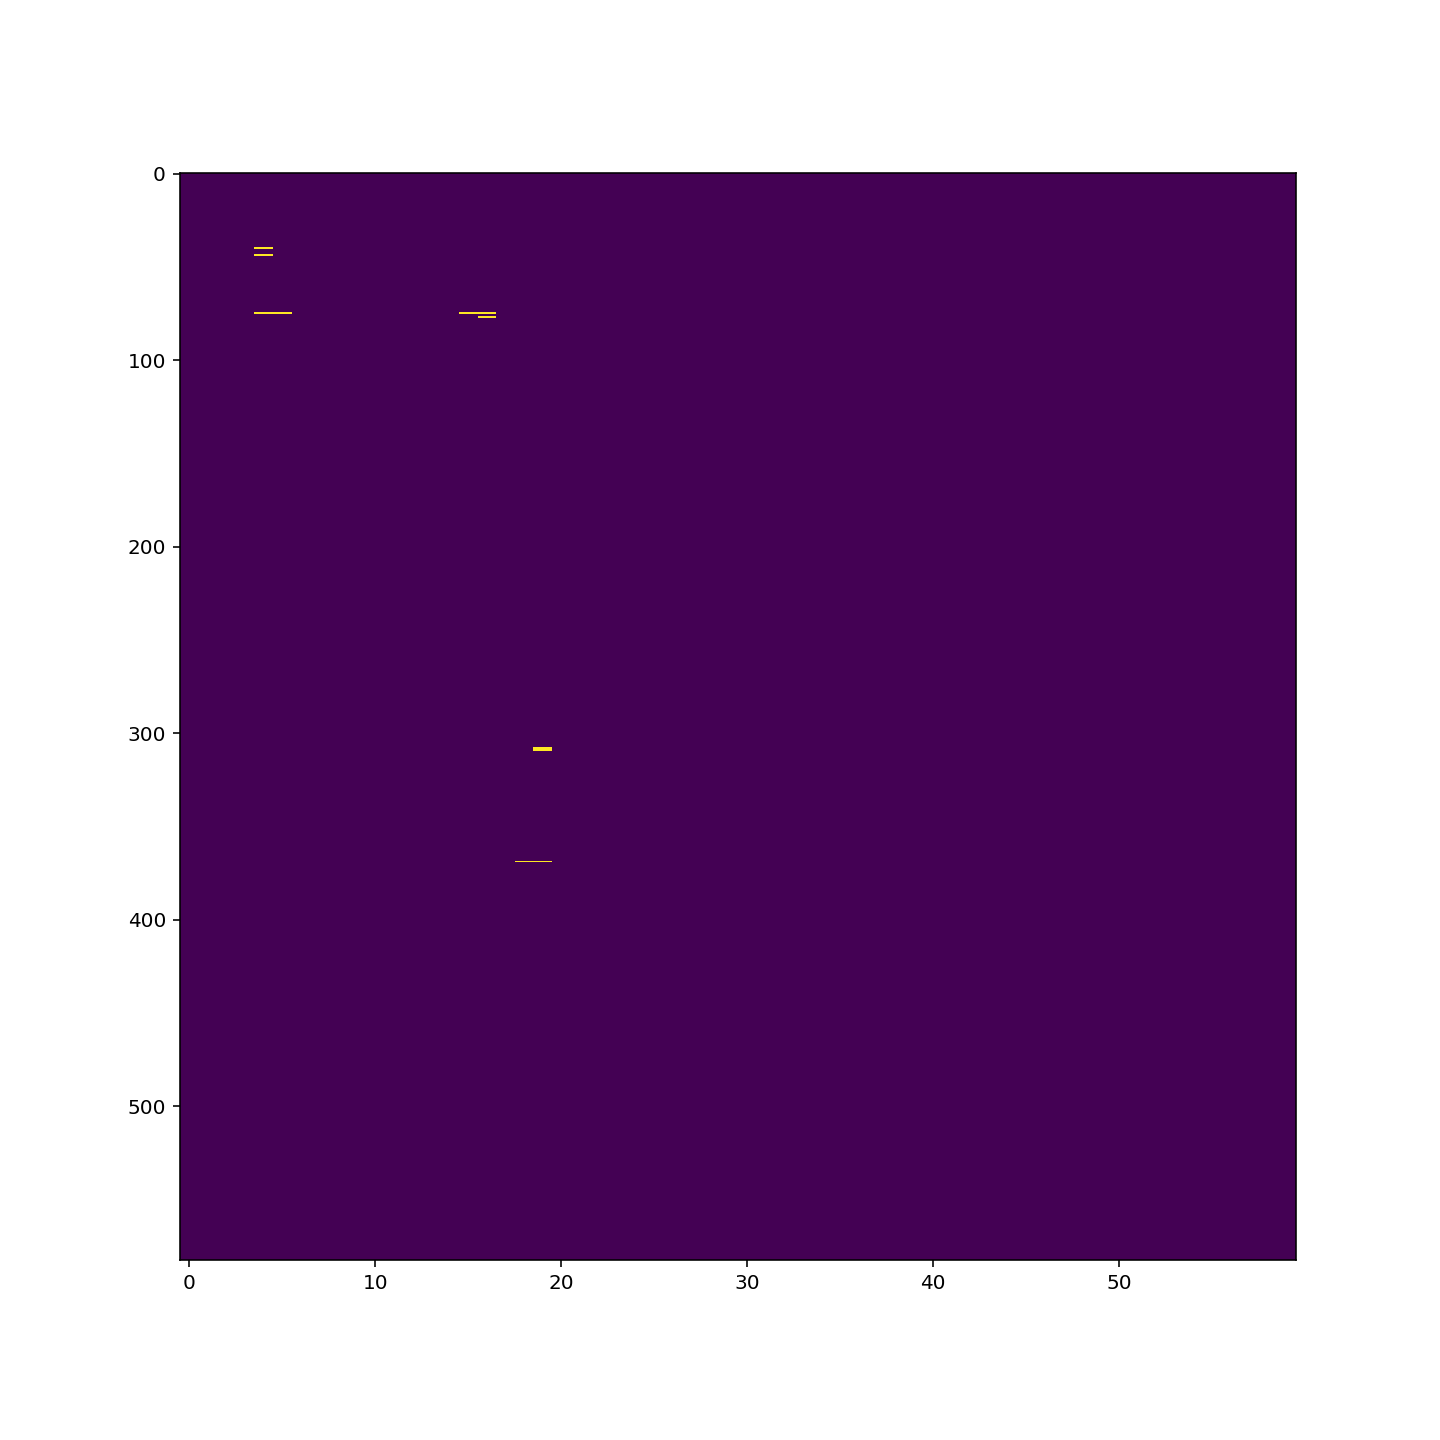

In [27]:
%matplotlib inline 
%matplotlib notebook
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ims = []
for i in range(50):
    data = trj_ppmap[0,i]
    im = plt.imshow(data, aspect='auto')
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat=False)
#plt.show()

#plt.show()